In [3]:
import ee
import numpy as np
import geopandas as gpd
import pandas as pd
import shapely
import glob
import os
from shapely.geometry import Polygon
from shapely.geometry import box
import matplotlib
import matplotlib.pyplot as plt
import rasterio as rio

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [5]:
ee.Authenticate()

Enter verification code:  4/1AbUR2VOYcJ4eXIRzluX9IPidnhtfhy2x7NkjPxmeEaaPvDdrdafr9iVFlY4



Successfully saved authorization token.


In [11]:
from ee_download import download_image_by_asset_path, Curler

In [12]:
# create bbox
# Read in gpkg

in_tiles = '/projects/Developer/icesat2_boreal/notebooks/radar_integration/Data/boreal_tiles_v003_agg10_bb_4326.gpkg'

ds = gpd.read_file(in_tiles)
tile = ds[ds['OBJECTID']==15]

#print(minx, maxx, miny, maxy)

In [13]:
tile.bounds

,minx,miny,maxx,maxy
18,77.264931,53.329627,95.054956,62.44571


In [19]:
# Get coords in EPSG 3857
ds_m = ds.to_crs("EPSG:3857")
tile_m = ds_m[ds_m['OBJECTID']==15]

In [36]:
# get counds of image
minx_m = tile_m.total_bounds[0]
miny_m = tile_m.total_bounds[1]
maxx_m = tile_m.total_bounds[2]
maxy_m = tile_m.total_bounds[3]

cols = round((maxx_m-minx_m)/30, 0)
rows = round((maxy_m-miny_m)/30, 0)
print(rows)

# make sub-footprint
print(f'rows = {rows}')
print(f'cols = {cols}')
#cols = 66013
#rows = 64048

minx = tile.bounds.iloc[0]['minx']
maxx = tile.bounds.iloc[0]['maxx']
miny = tile.bounds.iloc[0]['miny']
maxy = tile.bounds.iloc[0]['maxy']

64047.0
rows = 64047.0
cols = 66013.0


In [6]:
minx, miny, maxx, maxy

(77.26493080586134, 53.32962681552904, 95.05495590127494, 62.44571042554605)

In [7]:
sub_ftprint_nCols= (abs(minx - maxx)/cols)*500
offset_minx = minx
sub_ftprint_maxx = offset_minx + sub_ftprint_nCols
sub_ftprint_maxx

77.3996771822979

In [8]:
sub_ftprint_nRows = (abs(miny - maxy)/rows)*500
offset_miny = miny
sub_ftprint_maxy = offset_miny + sub_ftprint_nRows
sub_ftprint_maxy

53.400792844210784

In [9]:
sub_ftprint_bbox = box(offset_minx, offset_miny, sub_ftprint_maxx, sub_ftprint_maxy)
sub_ftprint_bbox.bounds

(77.26493080586134, 53.32962681552904, 77.3996771822979, 53.400792844210784)

In [10]:
sub_ftprint_bbox = gpd.GeoDataFrame(pd.DataFrame(['box'], columns = ['geometry']),crs ='epsg:4326',geometry = [sub_ftprint_bbox])


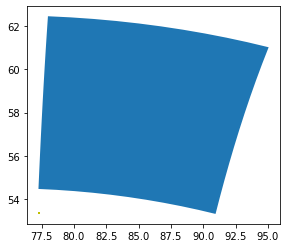

In [11]:
fig, ax = plt.subplots(1, 1)
tile.plot(ax=ax)
sub_ftprint_bbox.plot(ax=ax, facecolor='y')

In [12]:

# Get the extent of the shapefile poly
total_bounds = tile.total_bounds
# Get minX, minY, maxX, maxY
minX, minY, maxX, maxY = total_bounds

# Create a fishnet
x, y = (minX, minY)
geom_array = []

# Polygon Size
square_size = (abs(minx - maxx)/91153)*1500
while y <= maxY:
    while x <= maxX:
        geom = Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size
    
fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:4326')
fishnet.to_file('/projects/Developer/icesat2_boreal/notebooks/radar_integration/Data//fishnet_grid.gpkg', driver='GPKG')


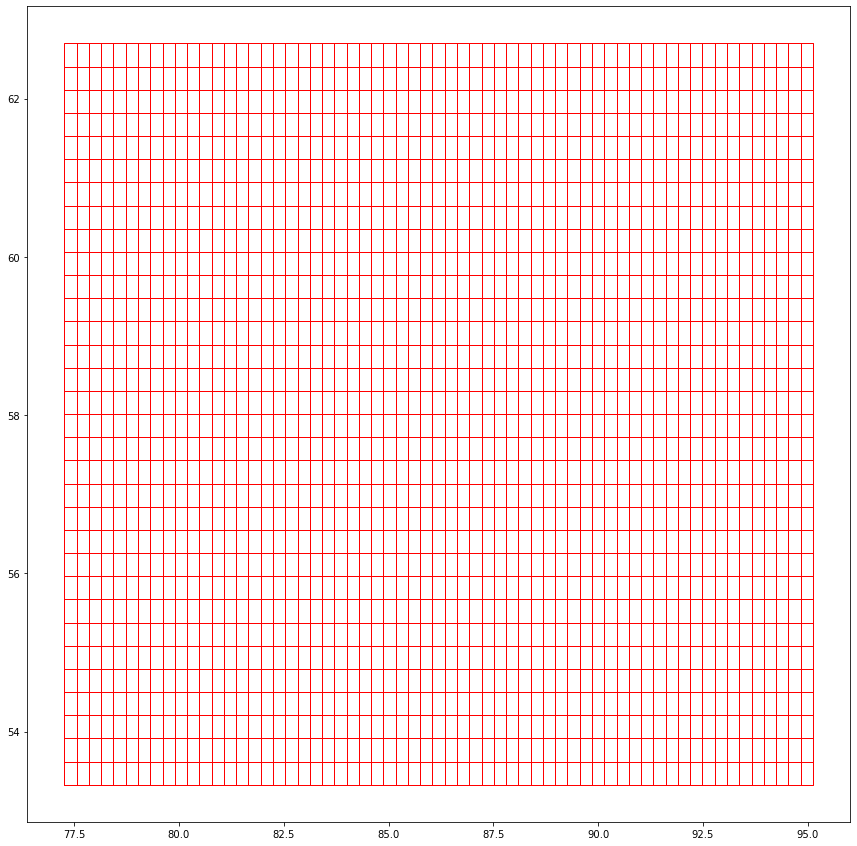

In [13]:
fishnet = gpd.read_file('/projects/Developer/icesat2_boreal/notebooks/radar_integration/Data/fishnet_grid.gpkg')
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
fishnet.plot(ax=ax, facecolor="None", edgecolor='red')



In [ ]:
for i in range(len(fishnet)):
    geom_bbox = list(fishnet.iloc()[i]['geometry'].bounds)

    print(geom_bbox)
    
    gee_geom = ee.Geometry.Rectangle(geom_bbox)
    
    
    try:
        print(f"downloading file {i}")
        downloaded_images = download_image_by_asset_path(
        asset_path = "projects/foreststructure/Circumboreal/S1_Composites_3857/s1_vv_vh_gamma_2016_pwr_15",
        output_folder = "/projects/Developer/icesat2_boreal/notebooks/radar_integration/Data/large_test/",
        region = gee_geom,
        idx = str(i)
        )
    except:
        pass
    
   



In [7]:
test_img = 'zip+file:///projects/Developer/icesat2_boreal/notebooks/radar_integration/Data/large_test/s1_vv_vh_gamma_2016_pwr_15-182.zip/s1_vv_vh_gamma_2016_pwr_15.VH_mean_frozen.tif'

dataset = rio.open(test_img)
ds = dataset.read(1)

print(ds)

[[0.04404236 0.04117454 0.03773302 ... 0.01764844 0.04404236 0.04404236]
 [0.03858797 0.03114628 0.04225456 ... 0.01837233 0.04404236 0.04404236]
 [0.03998941 0.0330636  0.04175149 ... 0.01712958 0.04404236 0.04404236]
 ...
 [0.0381299  0.03923148 0.03512004 ... 0.03006415 0.04404236 0.04404236]
 [0.0463756  0.03444975 0.04540258 ... 0.02243777 0.04404236 0.04404236]
 [0.04019415 0.04301744 0.05206455 ... 0.0177724  0.04404236 0.04404236]]


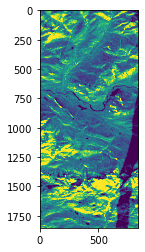

In [9]:
plt.imshow(ds, vmin=np.percentile(ds,10), vmax=np.percentile(ds,90))